In [1]:
from __future__ import absolute_import, division, print_function

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import pydrake.solvers.mathematicalprogram as mp
from irispy import Polyhedron
import numpy as np
from collections import namedtuple
# from ipywidgets import interact, interactive, fixed
# import ipywidgets as widgets
import time

In [12]:
class BoxAtlas(object):
    dim = 2
    g = 9.81
    mass = 10
    
    limb_bounds = [
        Polyhedron.fromBounds([0.5, -0.5], [1.0, 0.5]),    # right arm
        Polyhedron.fromBounds([0.0, -1.0], [0.5, -0.5]),   # right leg
        Polyhedron.fromBounds([-0.5, -1.0], [0.0, -0.5]),  # left leg
        Polyhedron.fromBounds([-1.0, -0.5], [-0.5, 0.5])  # left arm
    ]
    
    def __init__(self):
        pass

    
class BoxAtlasState(object):
    def __init__(self, robot, qcom=None, vcom=None, qlimb=None, vlimb=None):
        self.robot = robot
        if qcom is None:
            qcom = np.zeros(robot.dim)
        if vcom is None:
            vcom = np.zeros(robot.dim)
        if qlimb is None:
            qlimb = [np.zeros(robot.dim) for _ in robot.limb_bounds]
        if vlimb is None:
            vlimb = [np.zeros(robot.dim) for _ in robot.limb_bounds]
        
        self.qcom = qcom
        self.vcom = vcom
        self.qlimb = qlimb
        self.vlimb = vlimb
        
    def plot(self, ax):
        ax.plot(self.qcom[0], self.qcom[1], "bo")
        ax.quiver(self.qcom[0], self.qcom[1], self.vcom[0], self.vcom[1], scale=100)
        for k in range(len(self.qlimb)):
            ax.plot([self.qcom[0], self.qlimb[k][0]], [self.qcom[1], self.qlimb[k][1]], 'r-')

        
class BoxAtlasInput(object):
    def __init__(self, robot, flimb=None):
        self.robot = robot
        if flimb is None:
            flimb = [np.zeros(robot.dim) for _ in robot.limb_bounds]
        self.flimb = flimb

        
Surface = namedtuple("Surface", ["pose_constraints", "force_constraints"])
        
        
class Environment(object):
    def __init__(self, surfaces):
        self.surfaces = surfaces
        


In [42]:
def contact_stabilize(initial_state, env):
    robot = initial_state.robot
    prog = mp.MathematicalProgram()
    dt = 0.01
    horizon = 10
    dim = robot.dim
    fgravity = np.zeros(dim)
    fgravity[-1] = -robot.mass * robot.g
    num_limbs = len(robot.limb_bounds)
    num_surfaces = len(env.surfaces)
    Mf = 1000
    Mq = 10


    qcom = prog.NewContinuousVariables(dim, horizon)
    vcom = prog.NewContinuousVariables(dim, horizon)

    qlimb = [prog.NewContinuousVariables(dim, horizon) for i in range(num_limbs)]
    vlimb = [prog.NewContinuousVariables(dim, horizon) for i in range(num_limbs)]
    flimb = [prog.NewContinuousVariables(dim, horizon) for i in range(num_limbs)]
    zlimb = [prog.NewBinaryVariables(num_surfaces, horizon) for i in range(num_limbs)]

    # Midpoint integration
    for j in range(horizon - 1):
        for i in range(dim):
            prog.AddLinearConstraint(qcom[i, j + 1] == qcom[i, j] + 0.5 * vcom[i, j] * dt + 0.5 * vcom[i, j + 1] * dt)
            for k in range(num_limbs):
                prog.AddLinearConstraint(qlimb[k][i, j + 1] == qlimb[k][i, j] + 0.5 * vlimb[k][i, j] * dt + 0.5 * vlimb[k][i, j + 1] * dt)


    # Dynamics
    for j in range(horizon - 1):
        # pre-multiply each element by 0.5 to work around 
        # https://github.com/RobotLocomotion/drake/issues/5086
        f0 = sum(0.5 * f[:, j] for f in flimb)
        f1 = sum(0.5 * f[:, j + 1] for f in flimb)
        for i in range(dim):
            prog.AddLinearConstraint(vcom[i, j + 1] == vcom[i, j] + f0[i] + f1[i] + fgravity[i])

    # Contact constraints
    for k in range(num_limbs):
        for j in range(horizon):
            prog.AddLinearConstraint(np.sum(zlimb[k][:, j]) == 1)
            for s in range(num_surfaces):
                indicator = zlimb[k][s, j]
                A = surfaces[s].pose_constraints.getA()
                b = surfaces[s].pose_constraints.getB()
                for i in range(A.shape[0]):
                    prog.AddLinearConstraint(A[i, :].dot(qlimb[k][:, j]) <= b[i] + Mq - Mq * indicator)

                Af = surfaces[s].force_constraints.getA()
                bf = surfaces[s].force_constraints.getB()
                for i in range(Af.shape[0]):
                    prog.AddLinearConstraint(Af[i, :].dot(flimb[k][:, j]) <= bf[i] + Mf - Mf * indicator)
                    
    # Kinematics
    for k in range(num_limbs):
        A = robot.limb_bounds[k].getA()
        b = robot.limb_bounds[k].getB()
        for j in range(horizon):
            for i in range(A.shape[0]):
                prog.AddLinearConstraint(A[i, :].dot(qlimb[k][:, j]) - A[i, :].dot(qcom[:, j]) <= b[i])
            

    # Initial conditions
    for i in range(dim):
        prog.AddLinearConstraint(qcom[i, 0] == initial_state.qcom[i])
        prog.AddLinearConstraint(vcom[i, 0] == initial_state.vcom[i])
        for k in range(num_limbs):
            prog.AddLinearConstraint(qlimb[k][i, 0] == initial_state.qlimb[k][i])
            prog.AddLinearConstraint(vlimb[k][i, 0] == initial_state.vlimb[k][i])


    # Objectives
    all_force_vars = np.hstack([f.flatten() for f in flimb])
    Qf = 0.001
    prog.AddQuadraticCost(Qf * np.eye(len(all_force_vars)), np.zeros(len(all_force_vars)), all_force_vars)

    Qq = 10
    prog.AddQuadraticCost(Qq * np.eye(dim), np.zeros(dim), qcom[:,-1].flatten())

    Qv = 1
    prog.AddQuadraticCost(Qv * np.eye(dim), np.zeros(dim), vcom[:,-1].flatten())
    
    status = prog.Solve()
    print(status)
    
    qcom = prog.GetSolution(qcom)
    vcom = prog.GetSolution(vcom)
    qlimb = [prog.GetSolution(qlimb[k]) for k in range(num_limbs)]
    vlimb = [prog.GetSolution(vlimb[k]) for k in range(num_limbs)]
    flimb = [prog.GetSolution(flimb[k]) for k in range(num_limbs)]
    zlimb = [prog.GetSolution(zlimb[k]) for k in range(num_limbs)]
    
    states = [
        BoxAtlasState(robot, 
                      qcom=qcom[:, j],
                      vcom=vcom[:, j],
                      qlimb=[qlimb[k][:, j] for k in range(num_limbs)],
                      vlimb=[vlimb[k][:, j] for k in range(num_limbs)]) for j in range(horizon)
    ]
    inputs = [
        BoxAtlasInput(robot,
                      flimb=[flimb[k][:, j] for k in range(num_limbs)]) for j in range(horizon)
    ]
    return states, inputs, zlimb


In [43]:
surfaces = [
    Surface(Polyhedron.fromBounds([-1, -1], [1, -1]), 
            Polyhedron(np.array([[-1, -1], [1, -1]]), np.array([0, 0]))),
    Surface(Polyhedron.fromBounds([1, -1], [1, 1]),
            Polyhedron(np.array([[1, -1], [1, 1]]), np.array([0, 0]))),
    Surface(Polyhedron.fromBounds([-1, -1], [1, 1]),
            Polyhedron.fromBounds([0, 0], [0, 0]))
]

env = Environment(surfaces)
atlas = BoxAtlas()
initial_state = BoxAtlasState(atlas)
initial_state.qcom = np.array([0, 0])
initial_state.vcom = np.array([10.0, 0])
initial_state.qlimb = map(np.array, [[0.75, 0], [0.25, -0.75], [-0.25, -0.75], [-0.75, 0]])
initial_state.vlimb = map(np.array, [[0, 0], [0, 0], [0, 0], [0, 0]])

states, inputs, zlimb = contact_stabilize(initial_state, env)

SolutionResult.kSolutionFound


[None, None, None, None, None, None, None, None, None, None]

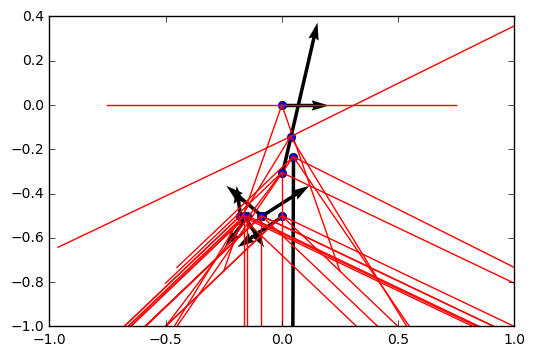

In [44]:
fig = figure()
ax = fig.add_subplot(1,1,1)

        
def drawstate(i):
    states[i].plot(ax)

[drawstate(i) for i in range(len(states))]